# Árboles de decisión

## Introducción teórica

Los Árboles de decisión son uno de los modelos de aprendizaje supervisado más importantes si nos centramos en la interpretabilidad del modelo.

Un árbol de decisión es un modelo de inteligencia artificial de **caja blanca**. Es decir: después de entrenarlo, sabremos exáctamente por qué una instancia es de una categoría y no de otra. Los árboles de decisión **pueden**, además, trabajar con valores atípicos sin ningún problema (podríamos decir que los detectan, como _DBSCAN_).

Además, uno de los modelos _ensemble_ (veremos qué significa esto, aunque con pocas palabras podría ser _conjunto de modelos_) más famosos es el ```RandomForest```, que simplemente agrupa cientos o miles de árboles de decisión.

Los árboles de decisión toman decisiones según las reglas que han aprendido durante el entrenamiento (bifurcaciones del árbol, que es binario), hasta llegar a un nodo hoja, que es justamente un resultado.

Como son modelos de caja blanca, los ejemplos visuales los vamos a construir nosotros mismos.

## Conjunto de datos y limpieza

Durante este cuadernillo nos propondremos clasificar distintos tipos de vino según sus propiedades químicas como el alcohol o la intensidad del color del vino.

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import datasets

In [ ]:
# lo cargo desde otro sitio para que veas las posibles diferencias
df_dict = datasets.load_wine()
X = pd.DataFrame(df_dict["data"], columns=df_dict["feature_names"])
y = pd.DataFrame(df_dict["target"], columns=["class"])

# las uno para poder crear y barajar los conjuntos de entrenamiento y testeo
df = pd.concat([X, y], axis=1)

# voy a cambiar la variable de salida de número a categoría para que no se vuelvan locos los modelos
df["class"] = df["class"].apply(lambda e: f"Class {e}")
df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,class
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,Class 0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,Class 0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,Class 0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,Class 0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,Class 0


### Grupo de entrenamiento y testeo

Como tenemos muy pocos datos (ver la siguiente celda), no tiene sentido separar el conjunto en entrenamiento y testeo (usaremos todo para entrenar nuestro modelo, así que no podremos testearlo. Nos conformaremos con la validación cruzada) como lo hemos hecho anteriormente. En este caso, tendremos que usar una de las técnicas más sofisticadas que vimos en ```301```.

In [ ]:
len(df)

178

Para usar o no una técnica estratificada, vamos a ver cómo de balanceadas están las clases a predecir.

In [ ]:
df["class"].value_counts()

,count
class,
Class 1,71
Class 0,59
Class 2,48


Hay cierto desnivel entre la clase 1 y 2, así que trabajaremos con la versión estratificada.

In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold

Recuerda que, al trabajar con este tipo de técnicas, tendremos que entrenar varios modelos por cada combinación de hiperparámetros. Veremos cómo hacerlo cuando toque (lo vamos a abstraer a una función).

El conjunto de datos con el que estamos trabajando no necesita ninguna limpieza (no hay valores sin sentido, ni nulos, ni categorías... --bueno, hay una, pero es la que queremos obtener así que no podemos tocarla--).

Sin embargo, sí que tiene valores con escalas muy distintas. Esto sería un problema para los modelos que trabajen con distancias, **sin embargo**, los árboles de decisión son agnósticos también a las escalas dispares, así que no tendremos ningún problema.

En resumen: no tocamos nada del conjunto de datos, está limpio.

## Ejemplo de clasificación

Vamos a ver cómo podemos entrenar un modelo de clasificación para los árboles de decisión.

In [ ]:
from sklearn.tree import DecisionTreeClassifier # recuerda que para problemas de regresión tendrás su versión Regressor
from sklearn.metrics import precision_score, recall_score # vamos a usar DOS métricas de clasificación (las explicamos después)

random_seed = 33

Definimos la función para entrenar una combinación de hiperparámetros.

In [ ]:
def evaluate_kfold(
    df, # el conjunto de datos completo
    model, # el modelo que se quiere entrenar
    n_splits, # la cantidad de divisiones del kfold, si vale 1, hace un train_test_split
    *metrics, # las métricas que se quieren utilizar
    hypermetric # la forma de combinar los resultados de las métricas
):
  # entrenamiento y objetivo
  X = df.iloc[:, :-1] # todas las columnas excepto la última
  y = df.iloc[:, -1] # la última

  # eleccion de la estrategia de división
  skfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)

  fold_scores = []
  for index, (train_idx, test_idx) in enumerate(skfold.split(X, y)):
    # división del conjunto de datos
    X_train, y_train, X_test, y_test = X.iloc[train_idx], y.iloc[train_idx], X.iloc[test_idx], y.iloc[test_idx]

    # entrenamos el modelo
    model = model.fit(X_train, y_train)

    # lo evaluamos
    train_score = []
    test_score = []
    for metric in metrics:
      train_score.append(metric(y_train, model.predict(X_train), average="weighted"))
      test_score.append(metric(y_test, model.predict(X_test), average="weighted"))

    # guardamos los resultados del fold
    fold_scores.append({"fold": index+1, "train": hypermetric(train_score), "test": hypermetric(test_score)})

  return pd.DataFrame(fold_scores)

Como vamos a aplicar la función ```recall_score``` a un problema multiclase (tenemos 3 clases, no 2), necesitamos modificar su atributo ```average```.

Además, definiremos la forma de fusionar las dos métricas. En este caso, es un problema de maximización. Además, ambas métricas son igual de importantes. Por eso, usaremos la **media armónica**, que a diferencia de la **media aritmética** penaliza que haya gran diferencia entre los valores.

In [ ]:
def harmonic_mean(numbers):
    # calculo la suma de los inversos
    inverse_sum = sum([1 / number for number in numbers])
    return len(numbers) / inverse_sum

Si bien es cierto que la métrica **precisión** puede entenderse perfectamente, ¿qué mide el **recall**?

Para contestar a esta pregunta, necesitamos hablar sobre los positivos y los negativos. Un valor **positivo** en un problema de clasificación es aquél valor que pertenece a la clase a la clase positiva (o identificable). Pongamos un ejemplo con dos categorías (que se entiende mejor).

Imaginemos que queremos clasificar a ciertas personas entre fumadores y no fumadores. En este caso, los positivos serían los fumadores y los negativos los no fumadores. Ahora bien, tenemos cuatro casos posibles tras la predicción de nuestro modelo:
- Que clasifique a un fumador como fumador (**verdadero positivo**; TP).
- Que clasifique a un no fumador como no fumador (**verdadero negativo**; TN).
- Que clasifique a un fumador como **NO** fumador (**falso negativo**; FN).
- Que clasifique a un no fumador como fumador (**falso positivo**; FP).

Quizá este último grupo, después de la pandemia 2020, te resulte familiar. En problemas médicos, se busca minimizar todo lo posible los **falsos negativos** (imagínate, el modelo dice que estás sanísimo, pero tienes la enfermedad) aunque se produzcan varios **falsos positivos** (el modelo dice que estás enfermo, pero realmente no lo estás). En otros entornos puede ser justo al revés. Por ejemplo, en un casino, puedes preferir los **falsos positivos** (el modelo te dice que apuestes aunque no deberías hacerlo; ir de farol, básicamente) que los **falsos negativos** (el modelo te dice que no apuestes, aunque deberías hacerlo).

Dependiendo de cómo se evalúen estos positivos y negativos, podemos hablar de varias métricas. Las más famosas:
- **accuracy**: $\frac{TP + TN}{TP + TN + FP + FN}$.

- **precision** (cuidado, porque la traducción es **odiosa**): $\frac{TP}{TP + FP}$. Mide los positivos que has **acertado**.

- **recall**: $\frac{TP}{TP + FN}$. Mide los positivos que has **detectado**.

Entrenemos nuestro modelo básico.

In [ ]:
model = DecisionTreeClassifier(random_state=random_seed)
score = evaluate_kfold(df, model, 5, precision_score, recall_score, hypermetric=harmonic_mean)
score

,fold,train,test
0,1,1.0,0.919771
1,2,1.0,0.945512
2,3,1.0,0.888889
3,4,1.0,1.000000
4,5,1.0,0.946207


Y ahora podemos mostrar los resultados. Cuando se trabaja con _folds_, es muy común utilizar diagramas de cajas.

/tmp/ipython-input-3163243295.py:1: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(score[["train", "test"]], labels=["train", "test"]);


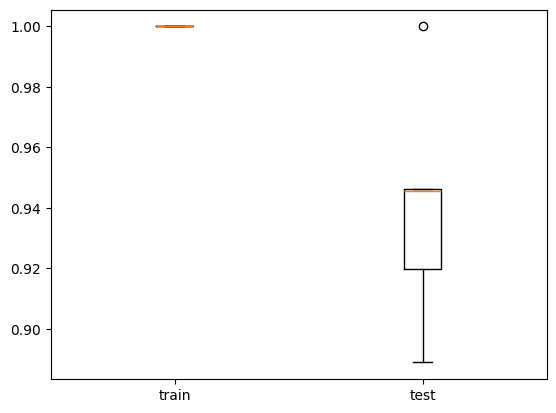

In [ ]:
plt.boxplot(score[["train", "test"]], labels=["train", "test"]);

Los resultados no son malos. Como podemos observar, el modelo básico alcanza la perfección en el entrenamiento (cuidado con el sobreajuste) y un 94% en el testeo. Incluso tenemos un _fold_ atípico que ha alcanzado la perfección en el testeo.

## Interpretabilidad

Al inicio del cuadernillo le hemos dado mucha importancia al hecho de que estos modelos sean **interpretables**. Esto significa que podemos entender el por qué de las decisiones que está tomando.

Vamos a ver cómo podemos hacer un diagrama con estas decisiones.

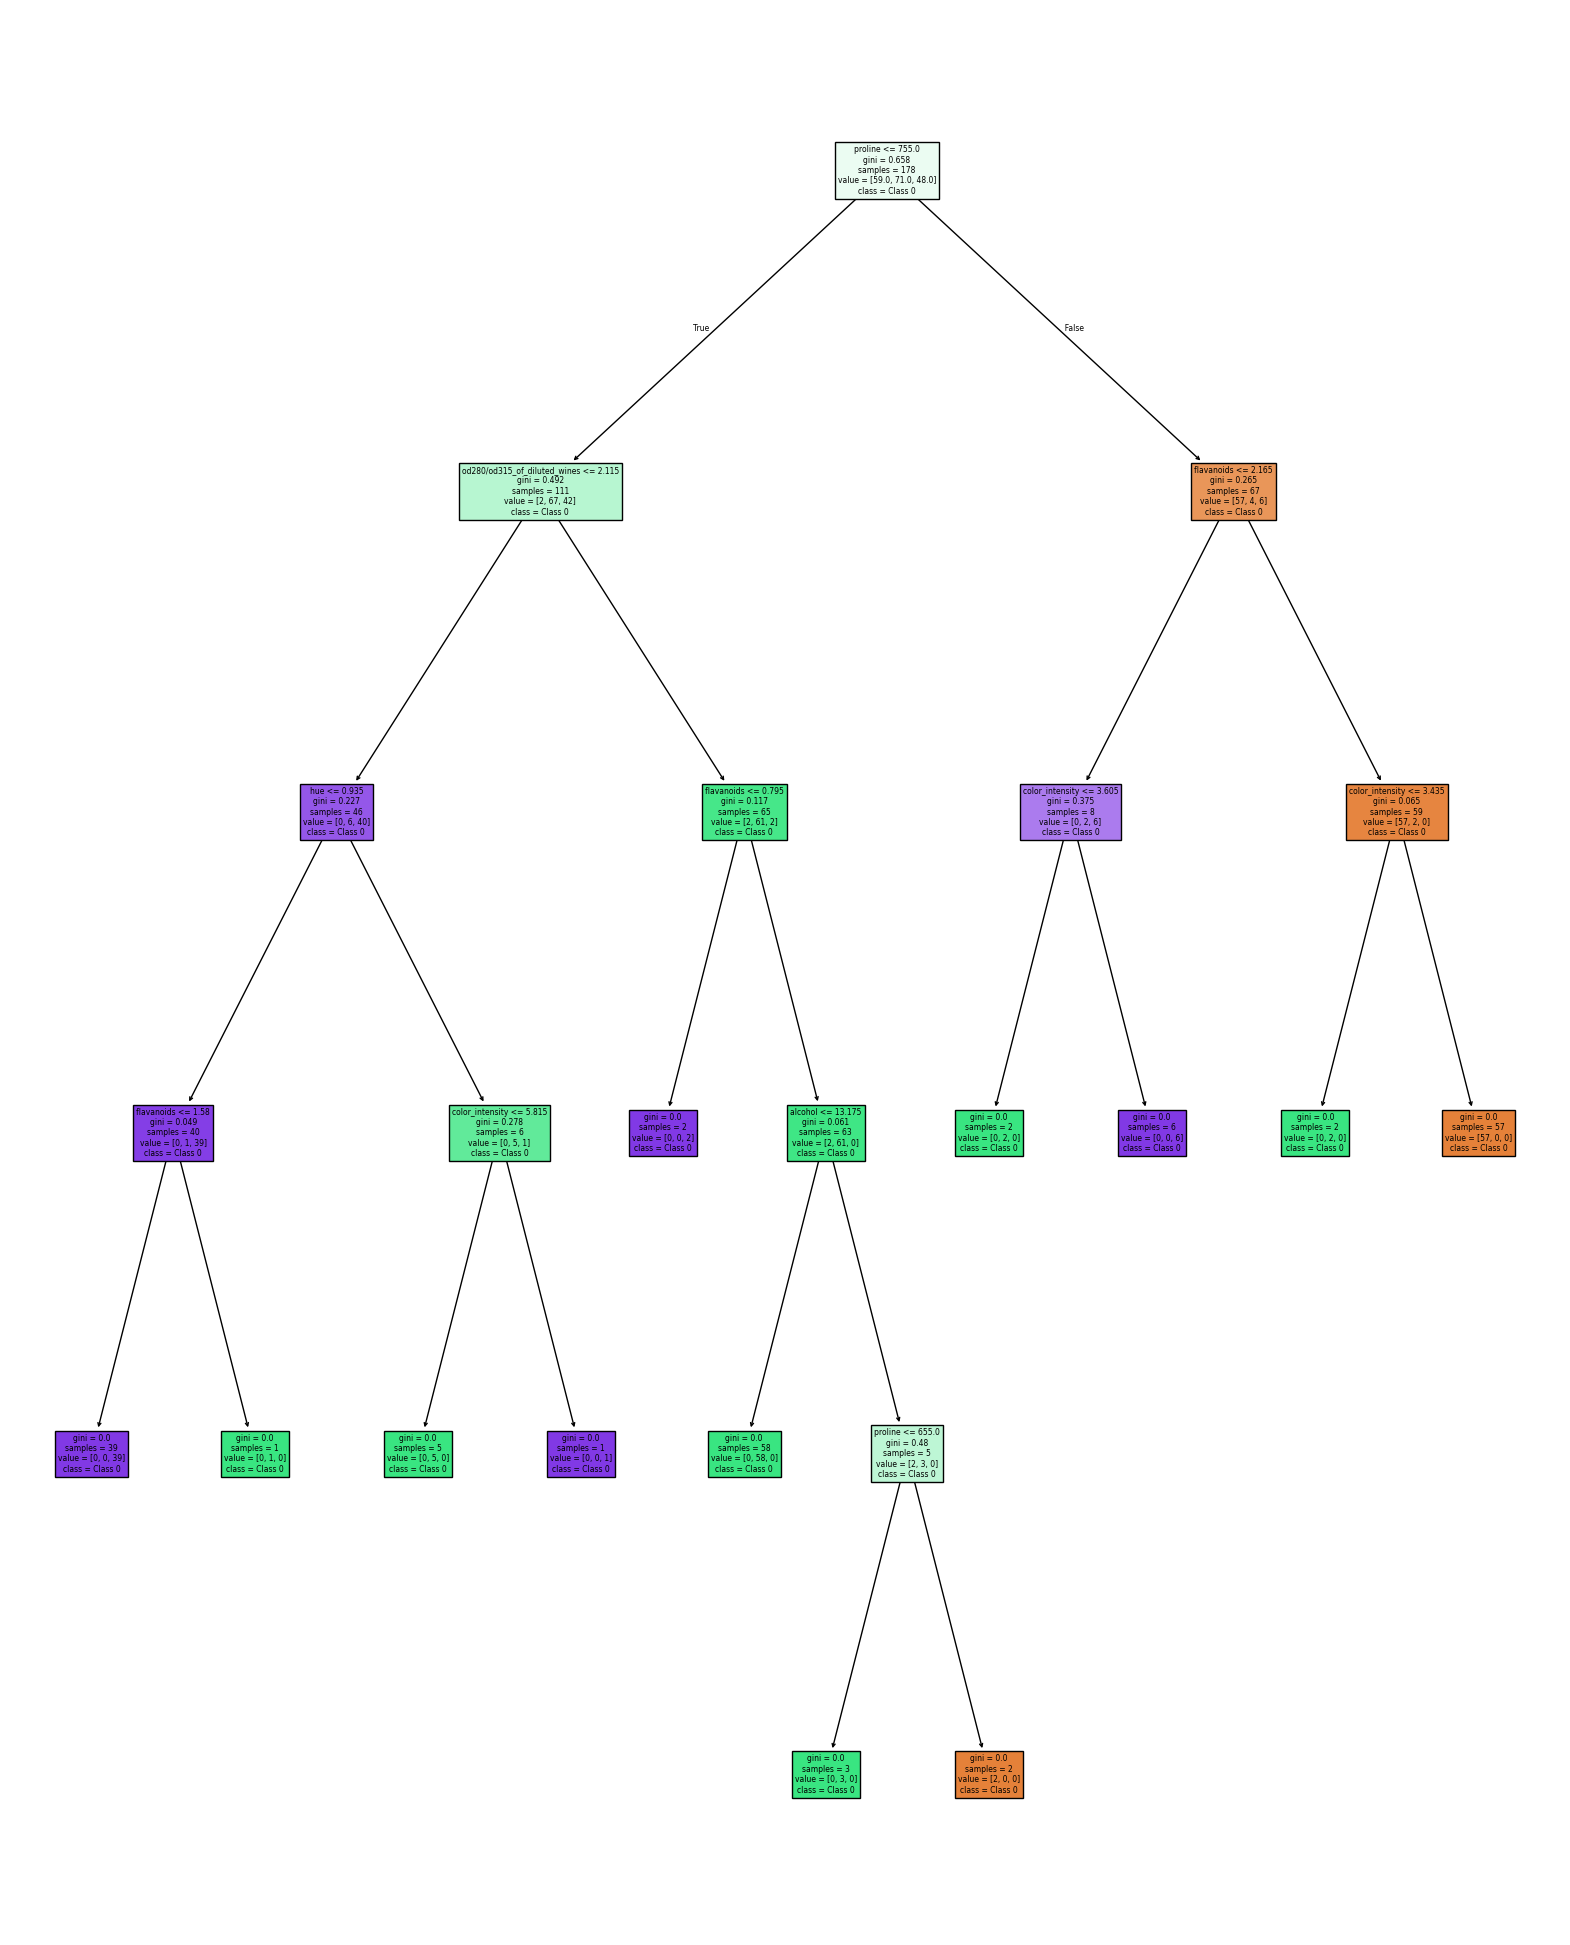

In [ ]:
from sklearn.tree import export_text, plot_tree

# los datos
X = df.iloc[:, :-1] # todas las columnas excepto la última
y = df.iloc[:, -1] # la última

# reentrenamos el modelo
model = DecisionTreeClassifier(random_state=random_seed)
model = model.fit(X, y)

# mostramos el diagrama
fig = plt.figure(figsize=(20, 25)) # puedes modificar esto según el tamaño del árbol
plot_tree(model, feature_names=df.columns[:-1], class_names=df.loc[:, df.columns[-1]], filled=True);

Como puedes ver, se genera un árbol binario en el que nos dan información por cada nodo:
- ```rule``` es la regla de decisión para todos los nodos que no sean hojas.
- ```gini``` es un índice que mide la impureza del árbol. Cuanto más abajo estemos, menor impureza habrá (mejor clasificadas estarán las clases).
- ```samples``` mide la cantidad de instancias del conjunto de datos han caído en ese nodo.
- ```value``` es un vector del tamaño del total de clases que indica qué elementos viajan por ese nodo.
- ```class``` indica la clase mayoritaria para ese nodo.

## Profundización

Veamos algunos de los parámetros que podemos modificar a la hora de entrenar un árbol de decisión.
- ```criterion```. Es el criterio elegido para medir la impureza. Por defecto toma el valor de ```gini```, pero podemos indicar también ```entropy``` y ```log_loss```.
- ```max_depth```. Mide la profundidad máxima del árbol. A menudo, un árbol de decisión se utiliza como primer modelo (por ser interpretable). Cuanto más pequeño sea el árbol, mejores tendrán que ser las reglas que dividan el conjunto de datos inicial en subgrupos. Es muy común querer conocer estas divisiones y después utilizar otros modelos.
- ```min_samples_split```. Determina la cantidad de instancias mínimas que debe haber en un nodo para buscar una regla que las divida.
- ```random_state```. Reproducibilidad de resultados.

En particular, son especialmente interesantes de optimizar los tres primeros.

## Optimización

Durante los cuadernillos anteriores hemos hecho a mano la optimización de los modelos simulando una ```GridSearch```. Vamos a aprovechar ahora para ver cómo podemos simplificar este proceso.

Importaremos el método ```GridSearch``` de ```sklearn``` que nos permitirá hacer justamente este tipo de búsqueda.

In [ ]:
from sklearn.model_selection import GridSearchCV

Ahora necesitamos definir nuestro modelo y las combinaciones de los hiperparámetros.

In [ ]:
model = DecisionTreeClassifier(random_state=random_seed)
param_grid = {
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": range(2, 7),
    "min_samples_split": range(2, 10)
}

Finalmente, podemos entrenarlo y esperar.

In [ ]:
gs = GridSearchCV(model, param_grid=param_grid, cv=5) # cv son los folds
gs.fit(X, y);

Una vez terminado el entrenamiento, podemos obtener los mejores resultados.

In [ ]:
best_params = gs.best_params_
best_model = gs.best_estimator_

best_params, best_model

({'criterion': 'entropy', 'max_depth': 2, 'min_samples_split': 2},
 DecisionTreeClassifier(criterion='entropy', max_depth=2, random_state=33))

Y, por ejemplo, mostrarlo.

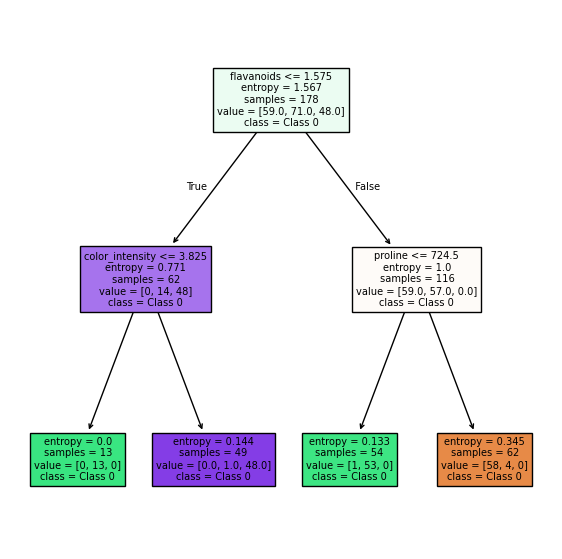

In [ ]:
fig = plt.figure(figsize=(7, 7)) # puedes modificar esto según el tamaño del árbol
plot_tree(best_model, feature_names=df.columns[:-1], class_names=df.loc[:, df.columns[-1]], filled=True);

Fíjate en que este modelo **NO** es perfecto como el que entrenábamos al principio, pero es más pequeño (cumple mejor la ley de la **parsimonia**).

# Resumen

Durante este cuadernillo hemos visto cómo trabajar con árboles de decisión y cómo utilizar una búsqueda de hiperparámetros utilizando el objeto ```GridSearch```. Recuerda que los árboles de decisión también pueden utilizarse para **regresión**. Además, has visto un ejemplo de un modelo que ignora la existencia de datos atípicos o no estandarizados y que es **interpretable**. También hemos explicado el funcionamiento general de las métricas de clasificación y qué son los positivos y negativos de una predicción.

En la vida real, los árboles son mucho menos perfectos; por ello, se suelen utilizar combinaciones de cientos o miles de ellos, creando **bosques aleatorios** (```RandomForest```), que será el primer tipo de modelo _ensemble_ que veamos.